# Importing Required Libraries

In [92]:
import librosa
import librosa.display
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM as lstm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import sys 

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  """


# Plotting the audio file's waveform and its spectrogram


In [3]:
mylist= os.listdir('RawData')

##Plotting the audio file's waveform and its spectrogram

data, sampling_rate = librosa.load('RawData/03-02-01-01-01-02-16.wav')

In [4]:
type(mylist)


list

In [5]:
print(mylist[1800])


03-01-08-02-02-02-03.wav


In [94]:
print(mylist[400])


03-02-02-01-01-01-19.wav


In [6]:
print(mylist[400][6:-16])


02


Populating the interactive namespace from numpy and matplotlib


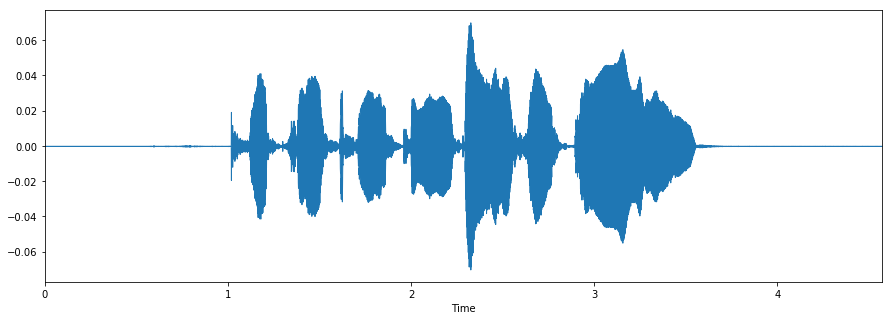

In [7]:
%pylab inline
import os
import pandas as pd
import librosa
import glob

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


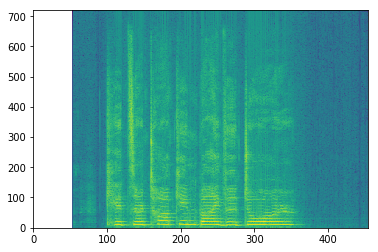

In [8]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read('RawData/03-02-01-01-01-02-16.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [93]:
sys.getsizeof(mylist)

21048

# Setting the labels 

In [50]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='02' and int(item[18:-4])%2==0:
        feeling_list.append('female_calm')
    elif item[6:-16]=='02' and int(item[18:-4])%2==1:
        feeling_list.append('male_calm')
    elif item[6:-16]=='03' and int(item[18:-4])%2==0:
        feeling_list.append('female_happy')
    elif item[6:-16]=='03' and int(item[18:-4])%2==1:
        feeling_list.append('male_happy')
    elif item[6:-16]=='04' and int(item[18:-4])%2==0:
        feeling_list.append('female_sad')
    elif item[6:-16]=='04' and int(item[18:-4])%2==1:
        feeling_list.append('male_sad')
    elif item[6:-16]=='05' and int(item[18:-4])%2==0:
        feeling_list.append('female_angry')
    elif item[6:-16]=='05' and int(item[18:-4])%2==1:
        feeling_list.append('male_angry')
    elif item[6:-16]=='06' and int(item[18:-4])%2==0:
        feeling_list.append('female_fearful')
    elif item[6:-16]=='06' and int(item[18:-4])%2==1:
        feeling_list.append('male_fearful')
    
labels = pd.DataFrame(feeling_list)


In [202]:
labels = pd.DataFrame(feeling_list)
labels[:10]


,0
0,female_fearful
1,female_angry
2,female_happy
3,female_happy
4,female_fearful
5,female_angry
6,female_calm
7,female_sad
8,female_sad
9,female_calm


# Getting the features of audio files using librosa


In [149]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load('RawData/'+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X,
                                            sr=sample_rate,
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1

In [150]:
df[:5]



,feature
0,"[-55.34954327651833, -55.58530507200249, -56.9..."
1,"[-55.0745316498102, -55.0745316498102, -55.074..."
2,"[-55.677100041008956, -55.42473315532577, -55...."
3,"[-49.55359492900165, -47.61808514016757, -47.4..."
4,"[-54.38846877583966, -54.38846877583966, -54.3..."


In [151]:
df3 = pd.DataFrame(df['feature'].values.tolist())


In [152]:
newdf = pd.concat([df3,labels], axis=1)


In [153]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})


In [154]:
rnewdf[:5]


,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-55.349543,-55.585305,-56.931356,-56.681721,-56.784476,-55.854030,-55.723222,-56.154396,-55.498716,-53.932386,...,-57.985374,-58.166031,-58.036148,-55.960418,-56.344690,-57.951899,-54.570671,-51.357930,-52.141321,female_fearful
1,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,-55.074532,...,-36.850959,-37.445835,-39.283033,-40.321981,-39.818532,-40.865937,-40.479914,-41.836896,-41.774274,female_angry
2,-55.677100,-55.424733,-55.242881,-54.337877,-51.845705,-50.900707,-51.864141,-53.123499,-51.652347,-52.188430,...,-36.282608,-37.351995,-36.989072,-36.189186,-38.254011,-42.123516,-41.551518,-19.894625,-10.708131,female_happy
3,-49.553595,-47.618085,-47.406584,-48.722094,-50.155449,-49.913823,-50.302380,-49.820660,-48.415183,-47.448050,...,-41.037263,-40.217180,-41.344359,-40.102269,-41.549201,-40.855933,-41.655109,-33.537083,-24.817997,female_happy
4,-54.388469,-54.388469,-54.388469,-54.388469,-54.388469,-54.388469,-54.388469,-54.388469,-54.388469,-54.388469,...,-45.915393,-45.318789,-46.843097,-46.521049,-45.249080,-46.252046,-48.015089,-49.467854,-50.442762,female_fearful


In [155]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)

rnewdf=rnewdf.fillna(0)

In [156]:
rnewdf=rnewdf.fillna(0)


# dividing the data into test and train


In [157]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [158]:
train[250:260]


,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
1358,-58.262100,-58.652775,-59.267947,-57.272160,-58.693130,-61.316115,-58.831958,-57.007540,-57.140935,-56.521399,...,-41.116872,-42.150595,-35.552959,-32.301514,-31.984045,-31.843784,-31.174469,-27.593319,-23.315893,male_fearful
673,-52.538647,-53.128990,-54.050570,-53.516565,-52.709473,-52.712034,-52.793545,-51.643998,-50.201408,-50.113418,...,-34.141533,-37.635140,-37.157385,-37.994794,-37.802047,-39.214273,-38.672783,-25.193360,-16.070777,female_fearful
1051,-46.142285,-47.091513,-49.638184,-52.281163,-51.847955,-51.197923,-50.490587,-48.458053,-48.034843,-48.582332,...,-31.652106,-29.802305,-28.473890,-29.412044,-30.255583,-29.789870,-27.093899,-25.939068,-21.975341,female_angry
1645,-53.915808,-53.890679,-53.699606,-53.366578,-53.414331,-51.962619,-51.702870,-50.795011,-50.524316,-50.677870,...,-26.425499,-27.277547,-27.780583,-28.780755,-26.044001,-24.974621,-22.341838,-21.274045,-20.113624,male_happy
1094,-39.248187,-39.267946,-39.934724,-39.509278,-40.693043,-40.119347,-40.159931,-41.144867,-42.636516,-42.084762,...,-37.529044,-36.612064,-36.406773,-36.786265,-38.316524,-39.493840,-40.084106,-40.984254,-40.847421,female_fearful
480,-49.626651,-49.626651,-49.626651,-49.626651,-49.626651,-49.626651,-49.626651,-49.626651,-49.626651,-49.626651,...,-41.813661,-44.129820,-46.296907,-47.937189,-48.107652,-47.130944,-49.147978,-49.498751,-48.562722,female_angry
243,-38.235766,-38.235766,-38.106197,-38.214851,-38.235766,-38.235766,-37.974174,-37.707408,-38.235766,-38.235766,...,-28.574450,-28.447073,-27.290143,-28.271499,-28.774063,-26.699220,-26.602960,-19.370298,-14.283687,female_angry
408,-45.747444,-46.371378,-46.525999,-46.268564,-46.582697,-46.181352,-45.579915,-46.083804,-45.408120,-45.775791,...,-22.886352,-25.235746,-25.272586,-27.477236,-28.119624,-27.754565,-28.038491,-24.248617,-19.442100,male_fearful
1602,-49.901835,-48.398933,-48.251979,-48.228168,-49.880415,-50.010761,-49.251305,-49.021509,-50.745767,-50.116512,...,-25.148138,-25.122208,-25.048582,-24.772586,-25.189401,-25.198136,-25.511486,-20.201374,-15.571602,male_calm
528,-47.371453,-47.371453,-47.371453,-47.371453,-47.371453,-47.371453,-47.371453,-47.371453,-47.371453,-47.371453,...,-47.039830,-47.331440,-47.371453,-47.371453,-47.176303,-47.371453,-47.371453,-47.371453,-47.371453,female_happy


In [159]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]


In [160]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [161]:
y_train


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [162]:
X_train.shape


(1495, 216)

In [163]:
## Changing dimension for  model

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [207]:
## Model
model = Sequential()
model.add(lstm(64,return_sequences=True,input_shape=(216,1 )))
model.add(Dropout(0.2))
model.add(lstm(32,return_sequences=True))
model.add(Dropout(0.2))
model.add(lstm(32))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

In [208]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 216, 64)           16896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 216, 64)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 216, 32)           12416     
_________________________________________________________________
dropout_11 (Dropout)         (None, 216, 32)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
__________

In [209]:
model.compile(loss='binary_crossentropy', optimizer=opt ,metrics=['accuracy'])


In [210]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=100, validation_data=(x_testcnn, y_test))


Train on 1495 samples, validate on 385 samples
Epoch 1/100
1495/1495 [==============================] - 29s 19ms/step - loss: 0.3249 - acc: 0.9000 - val_loss: 0.3246 - val_acc: 0.9000
Epoch 2/100
1495/1495 [==============================] - 25s 17ms/step - loss: 0.3236 - acc: 0.9000 - val_loss: 0.3235 - val_acc: 0.9000
Epoch 3/100
1495/1495 [==============================] - 25s 17ms/step - loss: 0.3224 - acc: 0.9000 - val_loss: 0.3218 - val_acc: 0.9000
Epoch 4/100
1495/1495 [==============================] - 26s 17ms/step - loss: 0.3195 - acc: 0.9000 - val_loss: 0.3187 - val_acc: 0.9000
Epoch 5/100
1495/1495 [==============================] - 25s 17ms/step - loss: 0.3165 - acc: 0.9000 - val_loss: 0.3146 - val_acc: 0.9000
Epoch 6/100
1495/1495 [==============================] - 26s 17ms/step - loss: 0.3131 - acc: 0.9000 - val_loss: 0.3102 - val_acc: 0.9000
Epoch 7/100
1495/1495 [==============================] - 25s 17ms/step - loss: 0.3100 - acc: 0.9000 - val_loss: 0.3057 - val_acc: 0

1495/1495 [==============================] - 25s 17ms/step - loss: 0.2435 - acc: 0.9041 - val_loss: 0.2475 - val_acc: 0.9036
Epoch 61/100
1495/1495 [==============================] - 25s 17ms/step - loss: 0.2531 - acc: 0.9043 - val_loss: 0.2444 - val_acc: 0.9044
Epoch 62/100
1495/1495 [==============================] - 25s 17ms/step - loss: 0.2449 - acc: 0.9037 - val_loss: 0.2550 - val_acc: 0.9039
Epoch 63/100
1495/1495 [==============================] - 25s 17ms/step - loss: 0.2451 - acc: 0.9044 - val_loss: 0.2510 - val_acc: 0.9039
Epoch 64/100
1495/1495 [==============================] - 26s 17ms/step - loss: 0.2463 - acc: 0.9038 - val_loss: 0.2562 - val_acc: 0.9023
Epoch 65/100
1495/1495 [==============================] - 25s 17ms/step - loss: 0.2438 - acc: 0.9047 - val_loss: 0.2454 - val_acc: 0.9039
Epoch 66/100
1495/1495 [==============================] - 25s 17ms/step - loss: 0.2430 - acc: 0.9050 - val_loss: 0.2459 - val_acc: 0.9036
Epoch 67/100
1495/1495 [=======================

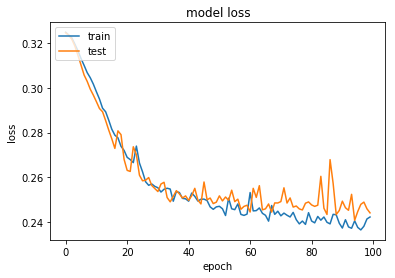

In [211]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [212]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /Users/akshaygoyal/Desktop/Empass/saved_models/Emotion_Voice_Detection_Model.h5 


In [213]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [214]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 90.34%


In [215]:
preds = loaded_model.predict(x_testcnn,
                         batch_size=32,
                         verbose=1)

385/385 [==============================] - 2s 5ms/step


In [216]:
preds


array([[4.03370410e-02, 3.67099675e-03, 1.96982697e-02, ...,
        2.51354933e-01, 2.39369676e-01, 1.17083624e-01],
       [1.85162611e-02, 1.91444170e-03, 2.86206603e-03, ...,
        1.72476038e-01, 2.41542593e-01, 2.41485372e-01],
       [1.16689764e-02, 2.37152982e-03, 2.33650906e-03, ...,
        1.65833950e-01, 2.17327982e-01, 2.51281202e-01],
       ...,
       [1.19055593e-02, 1.87681988e-03, 2.40029907e-03, ...,
        1.81370050e-01, 2.43050948e-01, 2.29339302e-01],
       [7.27091311e-03, 4.11539286e-01, 6.84475750e-02, ...,
        2.87077902e-03, 3.17208673e-04, 8.27656034e-03],
       [1.23760188e-02, 3.71669292e-01, 9.16141421e-02, ...,
        4.19188803e-03, 7.81712472e-04, 1.28840506e-02]], dtype=float32)

In [217]:
preds1=preds.argmax(axis=1)


In [218]:
preds1

array([7, 8, 6, 6, 6, 9, 6, 3, 5, 8, 3, 4, 7, 4, 9, 6, 3, 4, 0, 4, 5, 0,
       7, 2, 4, 4, 5, 6, 6, 7, 9, 8, 5, 6, 3, 0, 8, 4, 2, 5, 7, 6, 5, 4,
       0, 2, 7, 6, 3, 0, 9, 3, 5, 6, 2, 0, 8, 0, 8, 2, 8, 2, 4, 6, 8, 3,
       6, 3, 0, 3, 5, 8, 4, 6, 5, 6, 6, 4, 0, 3, 4, 2, 5, 4, 4, 8, 6, 4,
       6, 6, 4, 4, 4, 7, 8, 6, 6, 4, 2, 7, 9, 6, 6, 6, 7, 3, 2, 8, 7, 4,
       6, 3, 3, 0, 6, 8, 8, 2, 6, 0, 5, 9, 4, 4, 0, 5, 4, 0, 8, 7, 8, 5,
       6, 9, 4, 9, 4, 3, 9, 4, 8, 5, 5, 4, 6, 6, 9, 5, 0, 4, 8, 8, 8, 2,
       5, 8, 4, 2, 6, 4, 8, 4, 8, 8, 4, 0, 8, 9, 4, 3, 2, 3, 2, 4, 3, 2,
       6, 6, 4, 6, 3, 5, 5, 0, 0, 6, 4, 3, 3, 3, 2, 3, 6, 6, 2, 6, 9, 7,
       0, 6, 9, 4, 4, 2, 4, 4, 6, 0, 4, 2, 3, 0, 8, 0, 4, 7, 4, 3, 3, 8,
       8, 9, 4, 2, 6, 4, 3, 6, 0, 8, 5, 5, 6, 4, 3, 4, 2, 4, 9, 8, 2, 6,
       5, 7, 9, 2, 3, 5, 0, 2, 4, 6, 8, 6, 0, 6, 6, 3, 5, 5, 7, 3, 7, 5,
       2, 2, 4, 9, 6, 4, 2, 5, 6, 6, 8, 8, 2, 0, 4, 6, 8, 4, 8, 2, 9, 6,
       2, 4, 6, 8, 4, 3, 5, 2, 2, 4, 3, 4, 0, 6, 6,

In [219]:
abc = preds1.astype(int).flatten()


In [220]:
predictions = (lb.inverse_transform((abc)))


In [221]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_fearful
1,male_happy
2,male_calm
3,male_calm
4,male_calm
5,male_sad
6,male_calm
7,female_happy
8,male_angry
9,male_happy


In [222]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [223]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_angry
1,male_happy
2,male_happy
3,male_calm
4,male_sad
5,male_fearful
6,male_happy
7,female_calm
8,male_happy
9,male_happy


In [224]:
finaldf = actualdf.join(preddf)


In [225]:
finaldf[170:180]


,actualvalues,predictedvalues
170,female_angry,female_fearful
171,female_angry,female_happy
172,female_fearful,female_fearful
173,female_calm,female_sad
174,female_happy,female_happy
175,female_happy,female_fearful
176,male_sad,male_calm
177,female_happy,male_calm
178,female_calm,female_sad
179,male_sad,male_calm


In [226]:
finaldf.groupby('actualvalues').count()


,predictedvalues
actualvalues,
female_angry,42
female_calm,45
female_fearful,28
female_happy,41
female_sad,40
male_angry,39
male_calm,34
male_fearful,37
male_happy,47


In [227]:
finaldf.groupby('predictedvalues').count()


,actualvalues
predictedvalues,
female_angry,32
female_fearful,38
female_happy,41
female_sad,77
male_angry,35
male_calm,67
male_fearful,21
male_happy,52
male_sad,22


In [228]:
finaldf.to_csv('Predictions.csv', index=False)


In [229]:
finaldf.to_csv('Predictions.csv', index=False)


In [230]:
data, sampling_rate = librosa.load('output10.wav')


Populating the interactive namespace from numpy and matplotlib


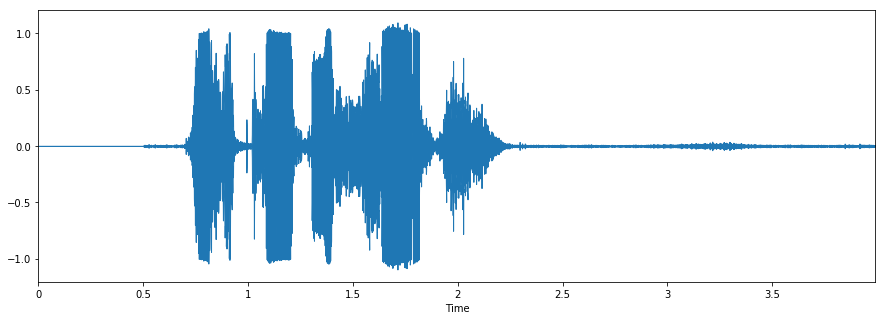

In [231]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [232]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('output10.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [233]:
livedf2= pd.DataFrame(data=livedf2)


In [234]:
livedf2 = livedf2.stack().to_frame().T


In [235]:
livedf2


,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-18.203564,-21.471836,-22.52221,-21.712259,-22.264288,-20.707904,-21.726444,-21.76865,-24.302736,-22.250634,...,-24.273819,-24.639939,-24.929152,-24.43919,-25.210171,-24.740646,-22.311913,-22.579805,-22.31466,-21.552436


In [236]:
twodim= np.expand_dims(livedf2, axis=2)


In [237]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 80ms/step


In [238]:
livepreds


array([[8.4179128e-03, 2.8230916e-04, 9.8994665e-04, 1.4021635e-03,
        8.7678854e-05, 1.9548006e-01, 1.3769686e-01, 2.3586421e-01,
        2.7265406e-01, 1.4712480e-01]], dtype=float32)

In [239]:
livepreds1=livepreds.argmax(axis=1)


In [240]:
liveabc = livepreds1.astype(int).flatten()


In [241]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['male_happy'], dtype=object)